In [ ]:
# Модуль для управления предупреждениями, подавляем лишние предупреждения, чтобы не засоряли вывод
import warnings

# Импорт библиотек для визуализации и численных вычислений
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Цветовые карты из Matplotlib для визуализации (например, активаций)
from matplotlib import cm

# Импорт основного фреймворка PyTorch
import torch
import torch.nn as nn
# Классы для загрузки и итерации по данным
from torch.utils.data import DataLoader
from torch.optim import Optimizer, Adam

# Модуль для преобразования изображений (новая версия transforms v2)
import torchvision.transforms.v2 as T
# Для очистки вывода в Colab (обновление графиков без дублирования)
from IPython.display import clear_output
# Работа с изображениями (открытие, изменение, сохранение)
from PIL import Image

# Для измерения времени выполнения (обучения, инференса и т.д.)
from time import perf_counter
# tqdm библиотека для отображения прогресса выполнения цикла
from tqdm import tqdm

# Игнорируем предупреждения
warnings.filterwarnings('ignore')
from torchvision.datasets import CIFAR10  # Класс датасета CIFAR-10
# import torchvision.transforms as T # Трансформации для изображений

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/NN_labs/lab_3/torch_dataset'

# Загружаем обучающую часть CIFAR-10
# dataset_train = CIFAR10(data_dir, train=True, download=True)
dataset_train = CIFAR10(data_dir, train=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_train.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])

In [ ]:
dataset_train.data.shape

(50000, 32, 32, 3)

In [ ]:
dataset_train[1]

(<PIL.Image.Image image mode=RGB size=32x32>, 9)

In [ ]:
np.min(dataset_train[0][0]), np.max(dataset_train[0][0])

(np.uint8(0), np.uint8(255))

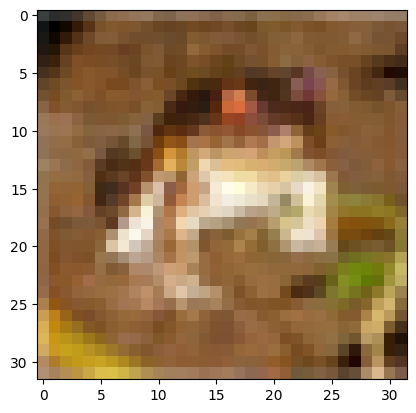

In [ ]:
plt.imshow(dataset_train[0][0]) # Отображаем изображение
plt.show()

In [ ]:
dataset_train = CIFAR10(data_dir, train=True, transform=T.ToTensor())
dataset_train.data.shape

(50000, 32, 32, 3)

In [ ]:
dataset_train[0][0].min(), dataset_train[0][0].max()

(tensor(0.), tensor(1.))

In [ ]:
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
print(means)
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))
print(stds)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [ ]:
# Создаём цепочку преобразований для изображений CIFAR-10
transforms = T.Compose([
    T.ToTensor(), # Преобразуем PIL.Image в torch.Tensor с форматом (C, H, W) и значения пикселей [0, 1]
    T.Normalize(mean=means, std=stds) # Нормализуем каждый канал: (x - mean) / std
])

In [ ]:
train_dataset = CIFAR10(data_dir, train=True, transform=transforms)
valid_dataset = CIFAR10(data_dir, train=False, transform=transforms)
# Создаём DataLoader для обучающего набора
train_loader = DataLoader(
    train_dataset, # Dataset
    batch_size=128, # Размер одного батча
    shuffle=True, # Перемешиваем данные на каждой эпохе
    num_workers=8, # Количество потоков для загрузки данных (ускоряет)
    pin_memory=True # Копирование данных в pinned memory для ускорения передачи на GPU
)
# Создаём DataLoader для валидационного набора
valid_loader = DataLoader(
    valid_dataset,
    batch_size=128, # Размер батча
    shuffle=False, # Не перемешиваем, порядок не важен
    num_workers=8,
    pin_memory=True
)

In [ ]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()  # Переводим модель в режим обучения (активируются dropout, batchnorm и т.д.)
    total_loss = 0      # Суммарная потеря за эпоху
    total_correct = 0   # Счётчик правильных предсказаний
    # Проходим по всем батчам обучающего датасета
    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)  # Переносим данные на GPU/CPU
        optimizer.zero_grad()  # Обнуляем градиенты, накопленные от предыдущих шагов
        output = model(x)      # Прямой проход (forward) через модель
        loss = loss_fn(output, y)  # Вычисляем функцию потерь
        loss.backward()        # Обратное распространение (вычисление градиентов)
        total_loss += loss.item()  # Накапливаем значение потерь
        # Считаем количество правильных предсказаний в батче
        total_correct += (output.argmax(dim=1) == y).sum().item()
        optimizer.step()       # Шаг оптимизации (обновление весов модели)
    # Возвращаем среднюю потерю на батч и точность на всем датасете
    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

In [ ]:
@torch.inference_mode()  # Отключает вычисление градиентов (экономит память и ускоряет оценку)
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()  # Переводим модель в режим оценки (выключаются dropout, batchnorm работает стабильно)
    total_loss = 0      # Суммарная потеря за весь датасет
    total_correct = 0   # Счётчик правильных предсказаний
    # Проходим по всем батчам в датасете
    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)  # Переносим данные на GPU/CPU
        output = model(x)       # Прямой проход через модель
        loss = loss_fn(output, y)  # Вычисляем функцию потерь
        total_loss += loss.item()   # Накапливаем потерю
        # Считаем количество правильных предсказаний в батче
        total_correct += (output.argmax(dim=1) == y).sum().item()
    # Возвращаем среднюю потерю и точность на всём датасете
    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

In [ ]:
sns.set(style='darkgrid')
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    # График ошибки (loss)
    plt.figure(figsize=(16, 8)) # Размер графика
    plt.title(title + ' loss') # Заголовок графика
    plt.plot(train_loss, label='Train loss') # Линия для потерь на обучающем наборе
    plt.plot(valid_loss, label='Valid loss') # Линия для потерь на валидационном наборе
    plt.legend() # Показываем легенду
    plt.show() # Отображаем график
    # График точности (accuracy)
    plt.figure(figsize=(16, 8)) # Размер графика
    plt.title(title + ' accuracy') # Заголовок графика
    plt.plot(train_accuracy, label='Train accuracy') # Линия для точности на обучающем наборе
    plt.plot(valid_accuracy, label='Valid accuracy') # Линия для точности на валидационном наборе
    plt.legend() # Показываем легенду
    plt.show() # Отображаем график

In [ ]:
from IPython.display import clear_output
import torch
import os

def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title):
    # Списки для хранения истории ошибки и точности
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    # Цикл по эпохам
    for epoch in range(num_epochs):
        # Обучение на одной эпохе
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        # Оценка модели на валидационном наборе
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)
        # Сохраняем историю для графиков
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        # Очищаем вывод и строим графики
        clear_output()
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        # Сохраняем контрольные точки модели и оптимизатора
        checkpoint_dir = "/content/drive/MyDrive/NN_labs/lab_3/checkpoints/"
        # os.makedirs(checkpoint_dir, exist_ok=True) # Создаём папку, если её нет
        # Модель
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"{model.__class__.__name__}_model_{epoch}.pt"))
        # Оптимизатор
        torch.save(optimizer.state_dict(), os.path.join(checkpoint_dir, f"{model.__class__.__name__}_optimizer_{epoch}.pt"))

In [ ]:
# Четверная нейронная сеть: глубокая CNN с BatchNorm и Dropout
class FourthModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 1-й сверточный блок
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32x32x32
            nn.BatchNorm2d(32),  # Нормализация по каналам
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Уменьшаем до 16x16x32
            nn.Dropout2d(p=0.2),  # Случайное "выключение" каналов для борьбы с переобучением
            # 2-й сверточный блок
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8x64
            nn.Dropout2d(p=0.2),  # Dropout после второго блока
            # 3-й сверточный блок
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),# 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 4x4x128
            nn.Dropout2d(p=0.2),  # Dropout после третьего блока
            # Полносвязная часть
            nn.Flatten(),                   # 4*4*128 = 2048 элементов
            nn.Linear(4 * 4 * 128, 512),   # Сокращаем до 512
            nn.BatchNorm1d(512),           # BatchNorm после линейного слоя
            nn.Dropout(p=0.3),             # Dropout для борьбы с переобучением
            nn.ReLU(),
            nn.Linear(512, 10)             # Выходной слой для 10 классов
        )

    def forward(self, x):
        # Прямой проход через всю сеть
        return self.net(x)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Выводим выбранное устройство
print(device)

loss_fn = nn.CrossEntropyLoss()


cuda:0


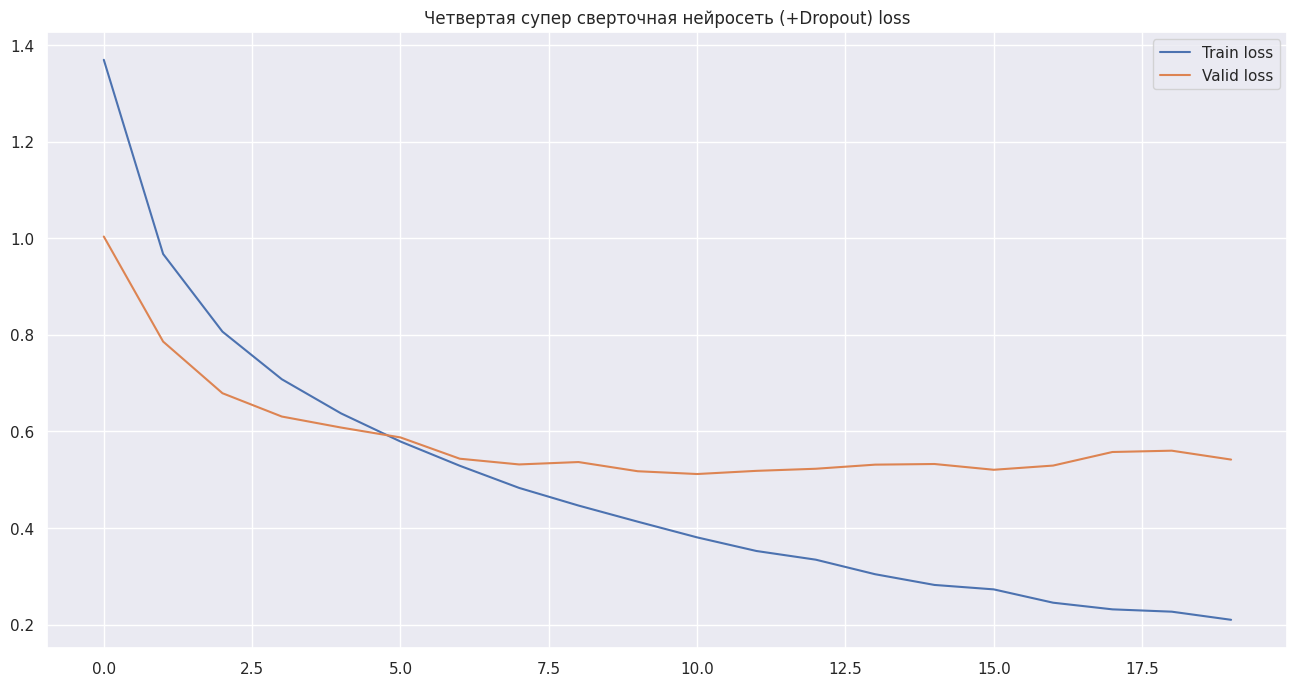

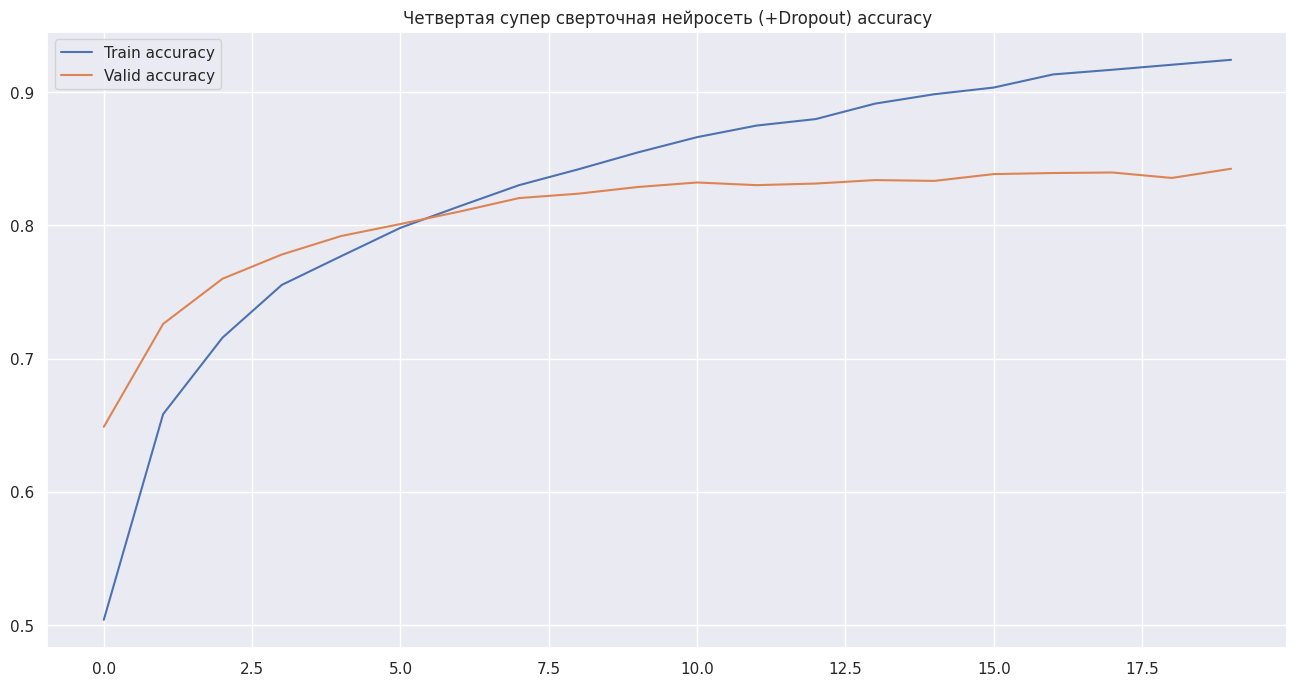

In [ ]:
# Создаём модель и переносим на устройство
model = FourthModel().to(device)           # Четвёртая, еще более продвинутая CNN с BatchNorm и Dropout
optimizer = Adam(model.parameters(), lr=1e-3)  # Оптимизатор Adam
# Запускаем обучение на 20 эпох
# train_loader и valid_loader — подготовленные DataLoader для CIFAR-10
# loss_fn — функция потерь CrossEntropyLoss
# device — GPU/CPU
fit(
    model,          # Модель FourthModel
    train_loader,   # Даталоадер для обучения
    valid_loader,   # Даталоадер для валидации
    optimizer,      # Оптимизатор Adam
    loss_fn,        # Функция потерь CrossEntropyLoss
    device,         # Устройство вычислений
    20,             # Количество эпох
    'Четвертая супер сверточная нейросеть (+Dropout)'  # Заголовок для графиков
)


In [ ]:
# Пятая нейронная сеть: глубокая CNN с BatchNorm и Dropout
class FiveModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 1-й сверточный блок
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32x32x32
            nn.BatchNorm2d(32),  # Нормализация по каналам
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),  # Уменьшаем до 16x16x32
            nn.Dropout2d(p=0.2),  # Случайное "выключение" каналов для борьбы с переобучением
            # 2-й сверточный блок
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),  # 8x8x64
            nn.Dropout2d(p=0.2),  # Dropout после второго блока
            # 3-й сверточный блок
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),# 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2),  # 4x4x128
            nn.Dropout2d(p=0.2),  # Dropout после третьего блока
            # Полносвязная часть
            nn.Flatten(),                   # 4*4*128 = 2048 элементов
            nn.Linear(4 * 4 * 128, 512),   # Сокращаем до 512
            nn.BatchNorm1d(512),           # BatchNorm после линейного слоя
            nn.Dropout(p=0.3),             # Dropout для борьбы с переобучением
            nn.ReLU(),
            nn.Linear(512, 10)             # Выходной слой для 10 классов
        )

    def forward(self, x):
        # Прямой проход через всю сеть
        return self.net(x)


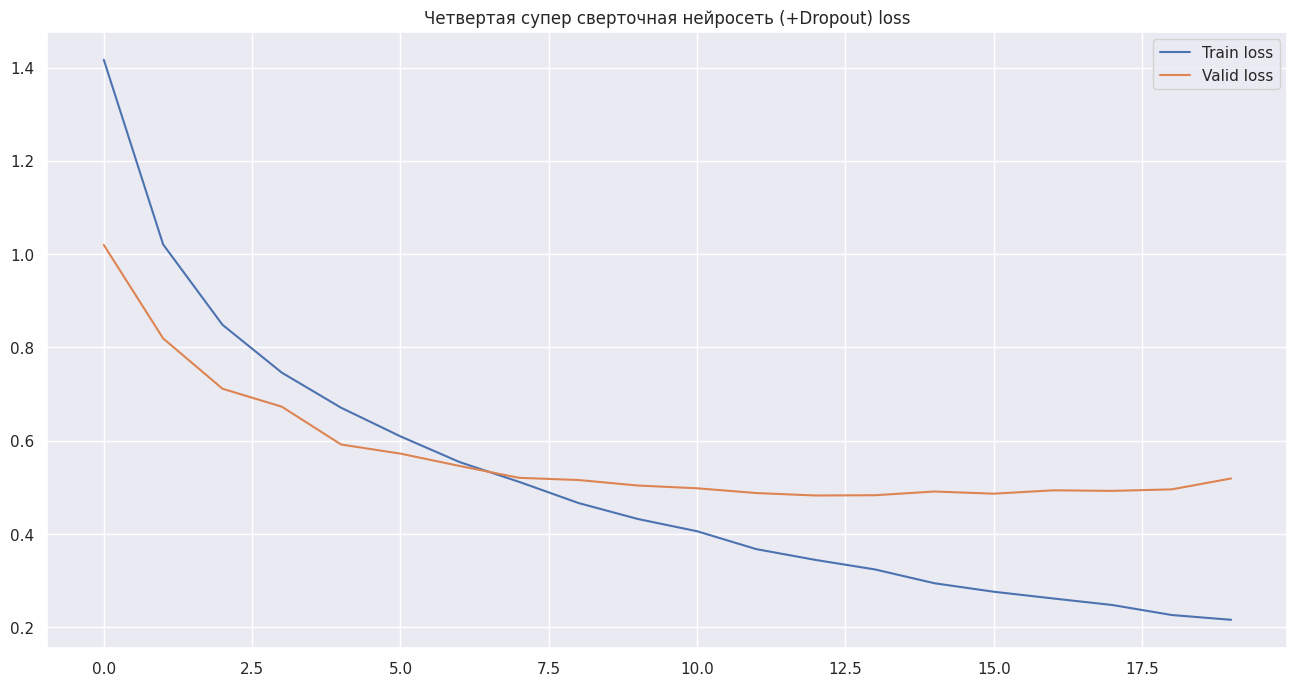

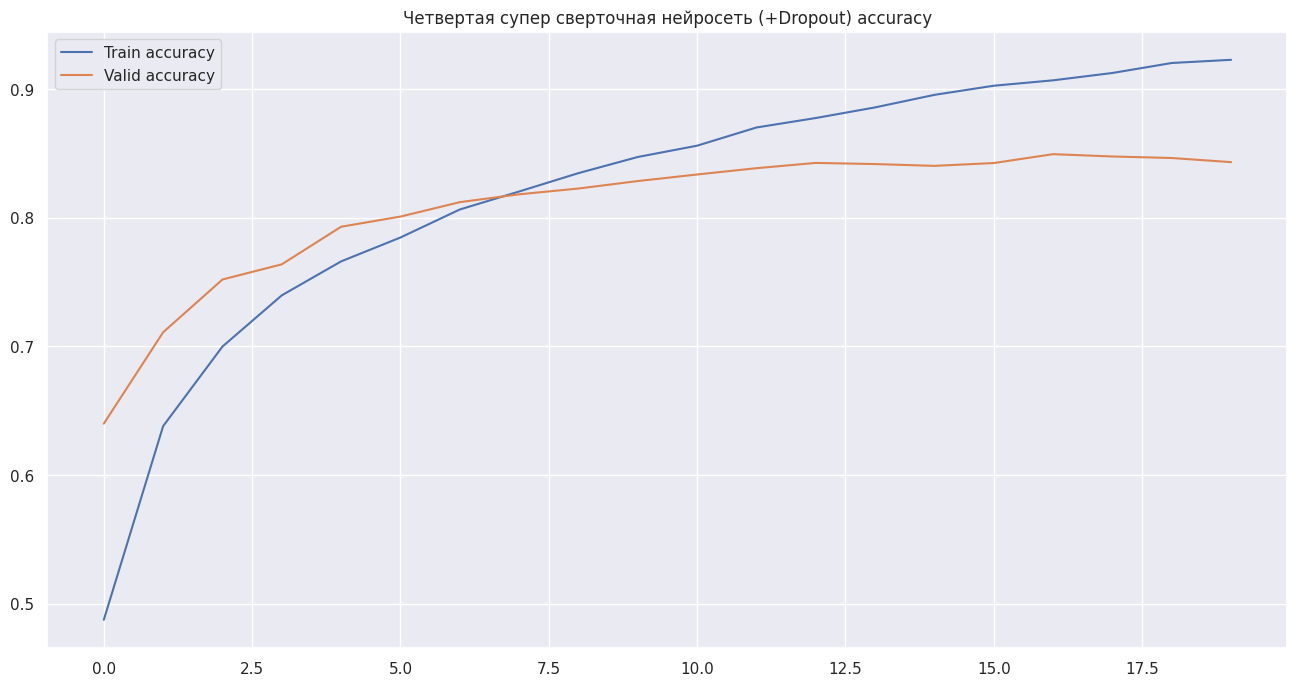

In [ ]:
# Создаём модель и переносим на устройство
model = FiveModel().to(device)           # Четвёртая, еще более продвинутая CNN с BatchNorm и Dropout
optimizer = Adam(model.parameters(), lr=1e-3)  # Оптимизатор Adam
# Запускаем обучение на 20 эпох
# train_loader и valid_loader — подготовленные DataLoader для CIFAR-10
# loss_fn — функция потерь CrossEntropyLoss
# device — GPU/CPU
fit(
    model,          # Модель FourthModel
    train_loader,   # Даталоадер для обучения
    valid_loader,   # Даталоадер для валидации
    optimizer,      # Оптимизатор Adam
    loss_fn,        # Функция потерь CrossEntropyLoss
    device,         # Устройство вычислений
    20,             # Количество эпох
    'Четвертая супер сверточная нейросеть (+Dropout)'  # Заголовок для графиков
)


In [ ]:
print(model.__class__)

<class '__main__.FiveModel'>


In [ ]:
model.__class__.__name__

'FiveModel'